In [16]:
import numpy as np
import awkward as ak
import uproot

ROOTFilePath = '/sdf/home/y/youngsam/data/atlas/neutralLLP_MS_1_4/Events/run_04_decayed_1/out.root'
f = uproot.open(ROOTFilePath)
t = f['Delphes']
refs = t['Track.Particle'].array()
refs[0][0]

<Record {ref: 668} type='TRef[ref: uint32]'>

## Mission:

Given a track, find out whether it belong to a LLP or not.


- `Track/Track.Particle` has references which point to indexes in `Particle` array.
- `Particle` has a PID stored in `Particle.PID`, as well as two mother indices located in `Particle.M{1,2}`, which point to indexes in `Particle` array.

The idea then will be to follow the mother indices until we reach the end of the chain of mothers, checking if any of them are LLPs. If so, then we know that that particle came from an LLP. If we use the index provided by the track, we can then check if the particle that the track came from came from an LLP or not.

`Particle` isn't saved using the `delphes_card_NNVX.tcl` card, so we will have to modify it by addying `add Branch Delphes/allParticles Particle GenParticle` at the end of it:

```tcl
module TreeWriter TreeWriter {

  add Branch Delphes/allParticles Particle GenParticle
  add Branch TrackMergerAll/tracks Track Track
  add Branch PileUpMerger/vertices Vertex Vertex
  add Branch SiliconHits/hits Hits Hit 
  add Branch DisplacedVertexDumper/displacedvertices DisplacedVertices DisplacedVertex 
}
```

then we can rerun Delphes and now the `Particle` branch will be able to be used.

In [13]:
# Track.Particle.ref gives us the index of the particle in the Particle branch
track = t['Track/Track.Particle'].array().ref[0]
partIdx = track[0]
print('The first track is associated with the particle at index', partIdx)

The first track is associated with the particle at index 668


In [6]:
# Let's find this particle.
PID = t['Particle.PID'].array()

# need to subtract 1 from partIdx because the array is 0-indexed
p = t['Particle.PID'].array()[0, partIdx-1]
print('The particle associated to track 0 in event 0 is', p)

# Let's find the mothers of this particle
M1 = t['Particle.M1'].array()  # mother 1
M2 = t['Particle.M2'].array()  # mother 2

print('The mothers of the particle are', M1[0, partIdx-1], M2[0, partIdx-1])

The particle associated to track 0 in event 0 is 321
The mothers of the particle are 663 664


In [27]:
from numba import njit

@njit
def checkForLLP(partIdx, mothers1, mothers2, PID) -> bool:
    
    # check if the particle is an LLP
    curr_pid = PID[partIdx]
    if (abs(curr_pid)>1000000 and abs(curr_pid)<1000040) or \
        (abs(curr_pid)>2000000 and abs(curr_pid)<2000016):
        return True

    # if not, check check the mothers
    else:
        m1 = mothers1[partIdx]
        m2 = mothers2[partIdx]

        if m1 < 0 and m2 < 0:
            return False
        elif m1 < 0:
            return checkForLLP(m2, mothers1, mothers2, PID)
        elif m2 < 0:
            return checkForLLP(m1, mothers1, mothers2, PID)
        else:
            return checkForLLP(m1, mothers1, mothers2, PID) or \
                   checkForLLP(m2, mothers1, mothers2, PID)
     
@njit
def checkForLLPArray(particleIdx, mothers1, mothers2, PID):
    output = np.zeros(particleIdx.shape[0]).astype(np.bool_)
    for i in range(particleIdx.shape[0]):
        output[i] = checkForLLP(particleIdx[i], mothers1, mothers2, PID)
    return output

In [62]:
refs     = [a.to_numpy() for a in t['Track.Particle'].array().ref]
mothers1 = [a.to_numpy() for a in t['Particle.M1'].array()]
mothers2 = [a.to_numpy() for a in t['Particle.M2'].array()]
pid      = [a.to_numpy() for a in t['Particle.PID'].array()]

ragged_array = ([checkForLLPArray(refs[i], mothers1[i], mothers2[i], pid[i]).tolist() for i in range(len(refs))])

# This arr is a jagged array of bools with the same structure as the Track.X branches, which tells you
# whether any of the particles associated with the track is an LLP or not.
arr = ak.Array(ragged_array)

In [80]:
llp_tracks = t['Track'].arrays(['Track.PT', 'Track.D0', 'Track.DZ', 'Track.Eta', 'Track.Phi'])[arr]
non_llp_tracks = t['Track'].arrays(['Track.PT', 'Track.D0', 'Track.DZ', 'Track.Eta', 'Track.Phi'])[~arr]

In [85]:
len(ak.ravel(llp_tracks['Track.PT'])), len(ak.ravel(non_llp_tracks['Track.PT']))

(52149, 181920)

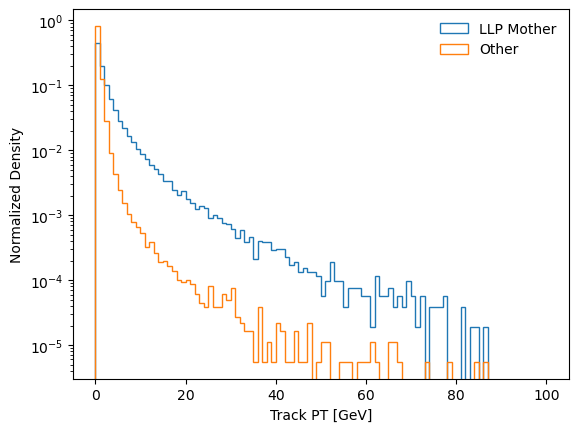

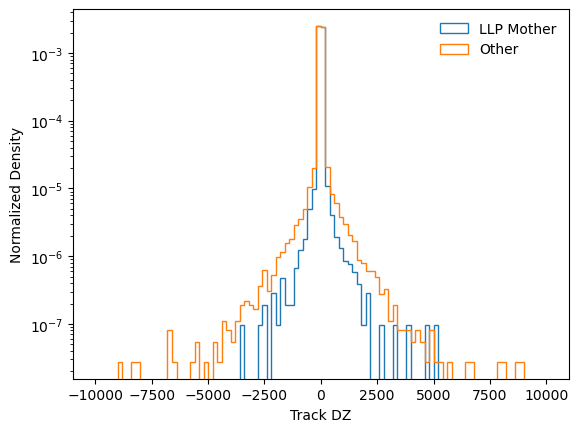

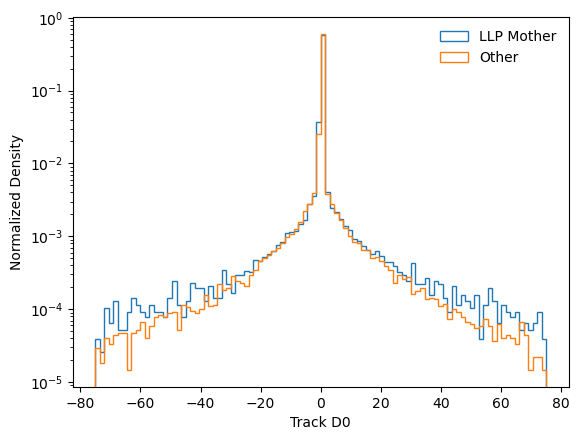

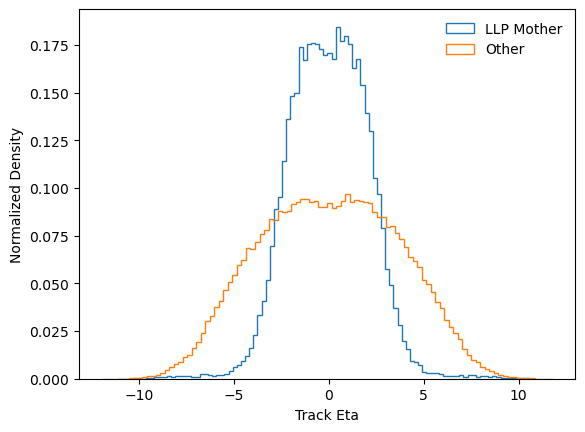

In [90]:
import matplotlib.pyplot as plt

llp_label = 'LLP Mother'
else_label = 'Other'
plt.hist(ak.concatenate(llp_tracks['Track.PT']), bins=100, range=(0, 100), histtype='step', label=llp_label, density=True)
plt.hist(ak.concatenate(non_llp_tracks['Track.PT']), bins=100, range=(0, 100), histtype='step', label=else_label, density=True)
plt.yscale('log')
plt.legend(frameon=False)
plt.xlabel('Track PT [GeV]')
plt.ylabel('Normalized Density')
plt.show()

plt.hist(ak.concatenate(llp_tracks['Track.DZ']), bins=100, range=(-10000,10000), histtype='step', label=llp_label, density=True)
plt.hist(ak.concatenate(non_llp_tracks['Track.DZ']), bins=100, range=(-10000,10000),  histtype='step', label=else_label, density=True)
plt.yscale('log')
plt.legend(frameon=False)
plt.xlabel('Track DZ')
plt.ylabel('Normalized Density')
plt.show()

plt.hist(ak.concatenate(llp_tracks['Track.D0']), bins=100, range=(-75,75), histtype='step', label=llp_label, density=True)
plt.hist(ak.concatenate(non_llp_tracks['Track.D0']), bins=100, range=(-75,75), histtype='step', label=else_label, density=True)
plt.yscale('log')
plt.legend(frameon=False)
plt.xlabel('Track D0')
plt.ylabel('Normalized Density')
plt.show()

plt.hist(ak.concatenate(llp_tracks['Track.Eta']), bins=100, histtype='step', label=llp_label, density=True)
plt.hist(ak.concatenate(non_llp_tracks['Track.Eta']), bins=100, histtype='step', label=else_label, density=True)
# plt.yscale('log')
plt.legend(frameon=False)
plt.xlabel('Track Eta')
plt.ylabel('Normalized Density')
plt.show()